In [1]:
import os
import numpy as np
import tifffile as tiff
from tqdm import tqdm
from scipy.sparse import lil_matrix
from scipy.ndimage import center_of_mass

In [22]:
def compute_jaccard_index(gt, pred):
    intersection = np.logical_and(gt > 0, pred > 0)
    union = np.logical_or(gt > 0, pred > 0)
    return np.sum(intersection) / np.sum(union)

def compute_sparse_jaccard(gt, pred):
    gt_labels = np.unique(gt)[1:]   # skip background (0)
    pred_labels = np.unique(pred)[1:]

    ious = lil_matrix((gt.max() + 1, pred.max() + 1), dtype=np.float32)

    # Build overlap pairs
    overlap_pairs = np.stack([gt.flatten(), pred.flatten()], axis=1)
    overlap_pairs = overlap_pairs[(overlap_pairs[:, 0] > 0) & (overlap_pairs[:, 1] > 0)]

    # Get unique overlapping label pairs
    pairs = np.unique(overlap_pairs, axis=0)

    for g, p in pairs:
        g_mask = gt == g
        p_mask = pred == p
        intersection = np.logical_and(g_mask, p_mask).sum()
        union = np.logical_or(g_mask, p_mask).sum()
        if union > 0:
            ious[g, p] = intersection / union

    # Best match for each ground truth object
    iou_dense = ious.toarray()
    gt_present = np.unique(gt)[1:]  # skip background
    best_matches = [iou_dense[g].max() for g in gt_present]

    # Filter out zero-overlap matches
    nonzero_matches = [v for v in best_matches if v > 0]

    return np.mean(nonzero_matches) if nonzero_matches else 0.0

def compute_centroid_jaccard(gt, pred):
    gt_labels = np.unique(gt)
    gt_labels = gt_labels[gt_labels != 0]  # Skip background
    ious = []

    for g in gt_labels:
        # Get GT mask and compute centroid
        g_mask = gt == g
        centroid = center_of_mass(g_mask)
        centroid_zyx = tuple(int(round(c)) for c in centroid)

        # Bounds check
        if not all(0 <= c < s for c, s in zip(centroid_zyx, gt.shape)):
            continue

        pred_label = pred[centroid_zyx]
        if pred_label == 0:
            continue  # No match at centroid

        # Get predicted and GT masks
        pred_mask = pred == pred_label

        intersection = np.logical_and(g_mask, pred_mask).sum()
        union = np.logical_or(g_mask, pred_mask).sum()
        if union > 0:
            ious.append(intersection / union)

    return np.mean(ious) if ious else 0.0

def compute_binary_f1_and_counts(gt, pred):
    gt_binary = gt > 0
    pred_binary = pred > 0

    tp = np.logical_and(pred_binary, gt_binary).sum()
    fp = np.logical_and(pred_binary, ~gt_binary).sum()
    fn = np.logical_and(~pred_binary, gt_binary).sum()

    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0

    n_gt_objects = len(np.unique(gt)) - (1 if 0 in gt else 0)
    n_pred_objects = len(np.unique(pred)) - (1 if 0 in pred else 0)

    return {
        "binary_f1": f1,
        "gt_objects": n_gt_objects,
        "pred_objects": n_pred_objects
    }

def evaluate_all(gt_folder, pred_folder):
    metrics = []

    files = sorted(os.listdir(gt_folder))
    for fname in tqdm(files):
        gt_path = os.path.join(gt_folder, fname)
        pred_path = os.path.join(pred_folder, fname)
        if not os.path.exists(pred_path):
            print(f"Missing: {fname}")
            continue

        gt = tiff.imread(gt_path)
        pred = tiff.imread(pred_path)

        jac = compute_jaccard_index(gt, pred)
        sparse_jac = compute_sparse_jaccard(gt, pred)
        centroid_jac = compute_centroid_jaccard(gt, pred)
        binary_stats = compute_binary_f1_and_counts(gt, pred)


        metrics.append({
            "filename": fname,
            "jaccard": jac,
            "sparse_jaccard": sparse_jac,
            "centroid_jaccard": centroid_jac,
            **binary_stats
        })

    return metrics

def summarize_metrics(metrics):
    from statistics import mean

    print("\n--- Summary ---")
    print(f"Images processed: {len(metrics)}")
    print(f"Mean Jaccard Index: {mean([m['jaccard'] for m in metrics]):.4f}")
    print(f"Mean Sparse Jaccard: {mean([m['sparse_jaccard'] for m in metrics]):.4f}")
    print(f"Mean Centroid Jaccard: {mean([m['centroid_jaccard'] for m in metrics]):.4f}")
    print(f"Mean Binary F1 Score: {mean([m['binary_f1'] for m in metrics]):.4f}")

    total_gt = sum(m['gt_objects'] for m in metrics)
    total_pred = sum(m['pred_objects'] for m in metrics)
    print(f"Total GT objects: {total_gt}")
    print(f"Total Predicted objects: {total_pred}")


In [23]:
gt_folder = 'D:/stardist3d_live/newtraining_mari/RealMask/'
pred_folder = 'D:/stardist3d_live/newtraining_mari/RealMask_predicted/'

results = evaluate_all(gt_folder, pred_folder)
summarize_metrics(results)

100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


--- Summary ---
Images processed: 12
Mean Jaccard Index: 0.6986
Mean Sparse Jaccard: 0.6437
Mean Centroid Jaccard: 0.6477
Mean Binary F1 Score: 0.8212
Total GT objects: 886
Total Predicted objects: 984


In [24]:
from cellpose import models
from cellpose.io import imread
from glob import glob
import pandas as pd

In [59]:
def evaluate_cellpose_custom_model(raw_folder, model_path, output_csv="results.csv"):
    raw_files = sorted(glob(os.path.join(raw_folder, "*-8bit.tif")))

    # Map from filename stem to raw/gt file
    file_pairs = []
    for raw_path in raw_files:
        base = os.path.basename(raw_path).replace("-8bit.tif", "")
        gt_path = os.path.join(raw_folder, base + "-labels.tif")
        if os.path.exists(gt_path):
            file_pairs.append((base, raw_path, gt_path))

    model = models.CellposeModel(gpu=True, pretrained_model=model_path)
    results = []

    for stitch_threshold in np.arange(0.5, 0.7, 0.1):
        print(f"Evaluating stitch_threshold = {stitch_threshold:.1f}")
        for base, raw_path, gt_path in tqdm(file_pairs):
            img = imread(raw_path)
            #print(img.shape)
            gt = imread(gt_path)

            masks, _, _ = model.eval(
                img,
                channels = [0,0],
                normalize=True,
                #channel_axis = 1,
                #z_axis = 0,
                stitch_threshold=stitch_threshold,
                flow_threshold=1,
                cellprob_threshold=-1
            )
            #print(masks.shape)
            mask = remove_border_labels(masks)

            jaccard = compute_jaccard_index(gt, mask)
            sparse_jac = compute_sparse_jaccard(gt, mask)
            centroid_jac = compute_centroid_jaccard(gt, mask)
            binary_stats = compute_binary_f1_and_counts(gt, mask)

            results.append({
                "filename": base,
                "stitch_threshold": round(stitch_threshold, 1),
                "jaccard": jaccard,
                "sparse_jaccard": sparse_jac,
                "centroid_jaccard": centroid_jac,
                **binary_stats
            })

    df = pd.DataFrame(results)
    #df.to_csv(output_csv, index=False)
    #print(f"\nResults saved to {output_csv}")
    return df

from skimage.measure import regionprops
from skimage.segmentation import relabel_sequential

def remove_border_labels(mask_3d):
    """Remove 3D labels that touch XY (not Z) image borders."""
    zdim, ydim, xdim = mask_3d.shape
    border_labels = set()

    for region in regionprops(mask_3d):
        minz, miny, minx, maxz, maxy, maxx = *region.bbox,
        if minx == 0 or maxx == xdim or miny == 0 or maxy == ydim:
            border_labels.add(region.label)

    cleaned = mask_3d.copy()
    for lbl in border_labels:
        cleaned[mask_3d == lbl] = 0

    cleaned, _, _ = relabel_sequential(cleaned)
    return cleaned

In [60]:
df_cellpose = evaluate_cellpose_custom_model(
    raw_folder="D:/membrane segmentation gc/cellpose_testing",
    model_path="C:/Users/ghr283/.cellpose/models/mem_mneongreen2", 
    output_csv="cellpose_threshold_sweep.csv"
)

Evaluating stitch_threshold = 0.5


100%|██████████| 5/5 [00:51<00:00, 10.31s/it]


Evaluating stitch_threshold = 0.6


100%|██████████| 5/5 [00:50<00:00, 10.07s/it]


In [55]:
df_cellpose

,filename,stitch_threshold,jaccard,sparse_jaccard,centroid_jaccard,binary_f1,gt_objects,pred_objects
0,Untitled-1-1,0.5,0.715796,0.699374,0.660728,0.834360,43,58
1,Untitled-1-2,0.5,0.580339,0.391968,0.467275,0.734448,78,79
2,Untitled-1-3,0.5,0.496363,0.273470,0.412819,0.663426,95,54
3,Untitled-1-4,0.5,0.310429,0.503283,0.604249,0.473782,20,56
4,Untitled-1-5,0.5,0.717595,0.551870,0.591606,0.835581,103,96
5,Untitled-1-1,0.6,0.711494,0.696577,0.657864,0.831430,43,62
6,Untitled-1-2,0.6,0.579154,0.404444,0.470586,0.733499,78,80
7,Untitled-1-3,0.6,0.497305,0.288177,0.436365,0.664267,95,54
8,Untitled-1-4,0.6,0.308651,0.482424,0.577847,0.471709,20,54
9,Untitled-1-5,0.6,0.707535,0.586920,0.644668,0.828721,103,114


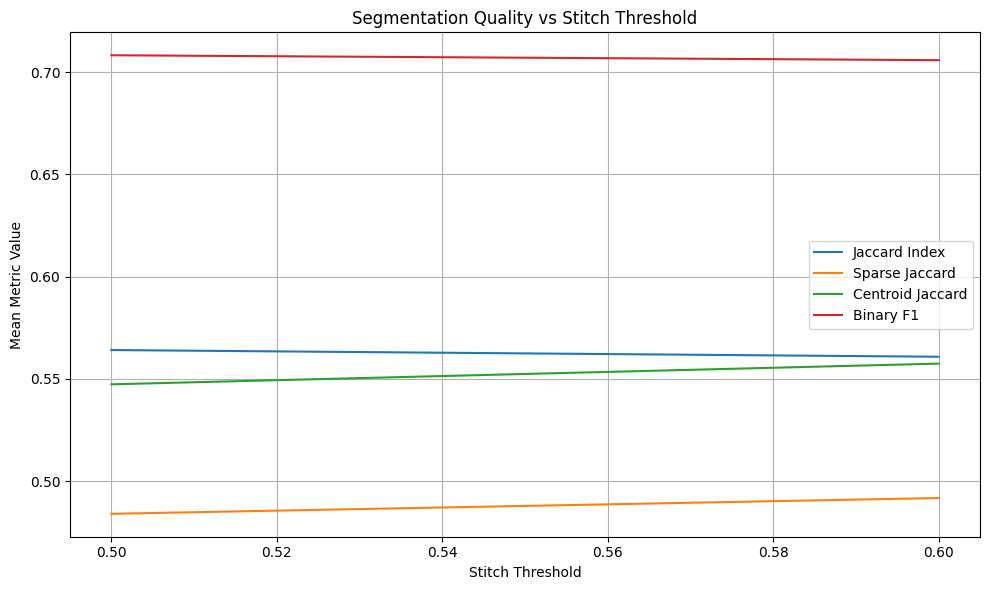

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by stitch_threshold and compute mean of each metric
grouped = df_cellpose.groupby("stitch_threshold").mean(numeric_only=True).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x="stitch_threshold", y="jaccard", label="Jaccard Index")
sns.lineplot(data=grouped, x="stitch_threshold", y="sparse_jaccard", label="Sparse Jaccard")
sns.lineplot(data=grouped, x="stitch_threshold", y="centroid_jaccard", label="Centroid Jaccard")
sns.lineplot(data=grouped, x="stitch_threshold", y="binary_f1", label="Binary F1")

plt.xlabel("Stitch Threshold")
plt.ylabel("Mean Metric Value")
plt.title("Segmentation Quality vs Stitch Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
from skimage.measure import regionprops, label

from joblib import Parallel, delayed
import multiprocessing

import gc

In [30]:
##functions
def filter_single_z_slice_objects(array):
    # Step 1: Count unique labels in each z-slice
    unique_labels_all_slices = np.array(0)
    for z in range(array.shape[0]):
        unique_labels_all_slices = np.append(unique_labels_all_slices,np.unique(array[z]))
    
    #Step 2: Identify labels that appear only once across all z-slices
    print("finding labels that are only in 1 z slice")
    unique_values, value_counts = np.unique(unique_labels_all_slices, return_counts=True)
    non_duplicate_values = unique_values[value_counts == 1]

    print(f"Found {len(non_duplicate_values)} 1 slice only labels out of {len(unique_values)} total labels")

    # Step 3: Filter out objects with labels present in only one z-slice
    #print("copying original array")
    filtered_array = np.copy(array)
    # Create a mask where True indicates the positions where 'array' matches any value in 'non_duplicate_values'
    mask = np.isin(array, non_duplicate_values)
    
    # Set the elements in `array` where mask is True to 0
    filtered_array[mask] = 0
    return filtered_array

# Function to calculate IoU between two binary masks (same shape)
def calculate_iou(slice1, slice2):
    intersection = np.logical_and(slice1, slice2).sum()
    union = np.logical_or(slice1, slice2).sum()
    if union == 0:
        return 0
    return intersection / union

# Function to expand slices for a single object
def expand_slices(label_id, z_centroid, y_centroid, x_centroid, membrane_filtered, membrane, z_slices, iou_threshold):
    current_object = membrane_filtered[z_centroid] == label_id
    orig_label_id = membrane[z_centroid, y_centroid, x_centroid]
    
    if orig_label_id != 0:
        expanded_slices = [(z_centroid, orig_label_id)]  # Start with the centroid slice
    else:
        expanded_slices = []
    
    # Expand upwards and downwards in Z
    for direction in [-1, 1]:  # -1 for upwards, 1 for downwards
        z = z_centroid + direction
        
        while 0 <= z < z_slices:  # Ensure z is within bounds
            candidate_slice = membrane[z]  # Get the original membrane slice at z
            candidate_object_value = candidate_slice[y_centroid, x_centroid]
            
            if candidate_object_value != 0:  # If object exists in this slice
                candidate_object = candidate_slice == candidate_object_value
                iou_score = calculate_iou(current_object, candidate_object)
                
                if iou_score > iou_threshold:
                    expanded_slices.append((z, candidate_object_value))  # Add this slice to the object
                else:
                    break  # Stop expanding in this direction if IoU is below threshold
            else:
                break  # No object found in this slice, stop

            z += direction  # Move up or down in Z

    return label_id, expanded_slices

def resolve_conflicts(expanded_objects, membrane_filtered, membrane, centroid_dict):
    slice_ownership = {}  # Map of (z, slice) -> label ownership
    final_expanded_objects = {}

    # First pass: Assign slices to the first object that claims them
    for label_id, slices in tqdm(expanded_objects.items()):
        final_expanded_objects[label_id] = []
        for z, obj_label in slices:
            if (z, obj_label) not in slice_ownership:
                slice_ownership[(z, obj_label)] = label_id
                final_expanded_objects[label_id].append((z, obj_label))
            else:
                # Conflict! Compare IoU with current owner
                current_owner = slice_ownership[(z, obj_label)]
                current_owner_z = int(centroid_dict[current_owner][0])
                new_owner_z = int(centroid_dict[label_id][0])
                iou_current = calculate_iou(membrane_filtered[current_owner_z] == current_owner,
                                            membrane[z] == obj_label)
                iou_new = calculate_iou(membrane_filtered[new_owner_z] == label_id,
                                        membrane[z] == obj_label)

                if iou_new > iou_current:
                    # Reassign slice to the new label
                    slice_ownership[(z, obj_label)] = label_id
                    final_expanded_objects[label_id].append((z, obj_label))
                    # Remove the slice from the previous owner's list
                    if current_owner in final_expanded_objects:
                        final_expanded_objects[current_owner] = [s for s in final_expanded_objects[current_owner] if s != (z, obj_label)]

    return final_expanded_objects



In [31]:
# Function to process a single membrane TIFF file
def process_membrane_image(input_mask, iou_threshold=0.3):
    
    # Prepare a copy of the membrane array for filtering
    membrane_filtered = np.copy(input_mask)

    # Label the membrane filtered array and extract the centroids
    labeled_membrane = label(membrane_filtered)
    object_props = regionprops(labeled_membrane)

    # Collect the centroids in a dictionary: key = label, value = (z, y, x) centroid coordinates
    centroid_dict = {}
    for prop in object_props:
        label_id = prop.label
        centroid_dict[label_id] = prop.centroid  # (z, y, x)

    z_slices = input_mask.shape[0]

    # Get the number of available CPU cores
    num_cores = multiprocessing.cpu_count()

    # First parallel step - Expanding objects
    with Parallel(n_jobs=num_cores) as parallel:
        expanded_objects = parallel(
            delayed(expand_slices)(label_id, int(round(z)), int(round(y)), int(round(x)), 
                                   labeled_membrane, input_mask, z_slices, iou_threshold)
            for label_id, (z, y, x) in tqdm(centroid_dict.items())
        )

    # Convert the result back to a dictionary
    expanded_objects = dict(expanded_objects)

    # Free resources and force garbage collection
    del parallel  # Explicitly remove the parallel object to free up memory
    gc.collect()  # Force garbage collection to free unused resources

    # Resolve the conflicts and get the final expanded objects
    final_expanded_objects = resolve_conflicts(expanded_objects, labeled_membrane, input_mask, centroid_dict)

    # Remove entries where the value (list of slices) is empty
    final_expanded_objects = {label_id: slices for label_id, slices in final_expanded_objects.items() if slices}

    # Final membrane array to store the result
    final_membrane_array = np.zeros_like(input_mask, dtype=np.int16)

    # Reconstruct the final relabelled array based on the expanded objects
    for label_id, slices in tqdm(final_expanded_objects.items()):
        for z, obj_label in slices:
            # Assign this object's label to the final membrane array at the slice
            final_membrane_array[z][input_mask[z] == obj_label] = label_id

    # Apply additional filtering if necessary (filter_single_z_slice_objects function)
    final_membrane_filtered = filter_single_z_slice_objects(final_membrane_array)

    # Save the final relabelled membrane array to the output folder
    #base_filename = os.path.basename(file_path)  # Get the original file name
    #output_path = os.path.join(output_folder, f"final_relabelled_{base_filename}")
    #tiff.imwrite(output_path, final_membrane_filtered)

    return final_membrane_filtered

In [39]:
def evaluate_with_postprocessing(raw_folder, model_path, gt_suffix="-labels.tif", stitch_threshold=0.6):
    raw_files = sorted(glob(os.path.join(raw_folder, "*-8bit.tif")))
    model = models.CellposeModel(gpu=True, pretrained_model=model_path)
    results = []

    for raw_path in tqdm(raw_files):
        base = os.path.basename(raw_path).replace("-8bit.tif", "")
        gt_path = os.path.join(raw_folder, base + gt_suffix)
        if not os.path.exists(gt_path):
            print(f"Missing GT: {base}")
            continue

        # 1. Run Cellpose
        img = imread(raw_path)
        masks, _, _ = model.eval(
            img,
            channels=[0, 0],
            normalize=True,
            stitch_threshold=stitch_threshold,
            flow_threshold=1,
            cellprob_threshold=-1,
        )

        # 2. Run post-processing pipeline on predicted mask
        masks_processed = process_membrane_image(masks, iou_threshold=0.6)

        pred = remove_border_labels(masks_processed)

        # 3. Load ground truth
        gt = tiff.imread(gt_path)

        # 4. Compute metrics
        jaccard = compute_jaccard_index(gt, pred)
        sparse_jac = compute_sparse_jaccard(gt, pred)
        centroid_jac = compute_centroid_jaccard(gt, pred)
        binary_stats = compute_binary_f1_and_counts(gt, pred)

        results.append({
            "filename": base,
            "jaccard": jaccard,
            "sparse_jaccard": sparse_jac,
            "centroid_jaccard": centroid_jac,
            **binary_stats
        })

    df = pd.DataFrame(results)
    return df


In [40]:
df = evaluate_with_postprocessing(raw_folder="D:/membrane segmentation gc/cellpose_testing",
    model_path="C:/Users/ghr283/.cellpose/models/mem_mneongreen2")

100%|██████████| 195/195 [00:00<00:00, 5232.05it/s]


finding labels that are only in 1 z slice
Found 98 1 slice only labels out of 196 total labels


100%|██████████| 323/323 [00:00<00:00, 14867.22it/s]


finding labels that are only in 1 z slice
Found 205 1 slice only labels out of 324 total labels


100%|██████████| 274/274 [00:00<00:00, 21058.37it/s]


finding labels that are only in 1 z slice
Found 189 1 slice only labels out of 275 total labels


100%|██████████| 259/259 [00:00<00:00, 12320.24it/s]


finding labels that are only in 1 z slice
Found 181 1 slice only labels out of 260 total labels


100%|██████████| 289/289 [00:00<00:00, 9009.42it/s]


finding labels that are only in 1 z slice
Found 114 1 slice only labels out of 290 total labels


100%|██████████| 5/5 [01:00<00:00, 12.07s/it]


In [43]:
def evaluate_slicewise_from_3d(raw_folder, model_path, gt_suffix="-labels.tif", stitch_threshold=0.6):
    raw_files = sorted(glob(os.path.join(raw_folder, "*-8bit.tif")))
    model = models.CellposeModel(gpu=True, pretrained_model=model_path)
    results = []

    for raw_path in tqdm(raw_files):
        base = os.path.basename(raw_path).replace("-8bit.tif", "")
        gt_path = os.path.join(raw_folder, base + gt_suffix)
        if not os.path.exists(gt_path):
            print(f"Missing GT: {base}")
            continue

        # Load 3D image and ground truth
        img_stack = imread(raw_path)
        gt_stack = tiff.imread(gt_path)

        # === Cellpose full-volume segmentation ===
        masks, _, _ = model.eval(
            img_stack,
            channels=[0, 0],
            normalize=True,
            stitch_threshold=stitch_threshold,
            flow_threshold=1,
            cellprob_threshold=-1,
        )

        # Post-process the full volume
        masks_processed = filter_single_z_slice_objects(masks)
        pred_stack = remove_border_labels(masks_processed)

        # === Per-slice evaluation ===
        for z in range(img_stack.shape[0]):
            gt_slice = gt_stack[z]
            pred_slice = pred_stack[z]

            if np.max(gt_slice) == 0 and np.max(pred_slice) == 0:
                continue  # Skip empty slices

            jaccard = compute_jaccard_index(gt_slice, pred_slice)
            sparse_jac = compute_sparse_jaccard(gt_slice, pred_slice)
            centroid_jac = compute_centroid_jaccard(gt_slice, pred_slice)
            binary_stats = compute_binary_f1_and_counts(gt_slice, pred_slice)

            results.append({
                "filename": base,
                "slice": z,
                "jaccard": jaccard,
                "sparse_jaccard": sparse_jac,
                "centroid_jaccard": centroid_jac,
                **binary_stats
            })

    return pd.DataFrame(results)


In [44]:
df_2d = evaluate_slicewise_from_3d(raw_folder="D:/membrane segmentation gc/cellpose_testing",
    model_path="C:/Users/ghr283/.cellpose/models/mem_mneongreen2")

100%|██████████| 38/38 [00:00<00:00, 2271.39it/s]


finding labels that are only in 1 z slice
Found 98 1 slice only labels out of 196 total labels


100%|██████████| 38/38 [00:00<00:00, 2215.17it/s]


finding labels that are only in 1 z slice
Found 207 1 slice only labels out of 326 total labels


100%|██████████| 38/38 [00:00<00:00, 1579.98it/s]


finding labels that are only in 1 z slice
Found 190 1 slice only labels out of 276 total labels


100%|██████████| 38/38 [00:00<00:00, 2126.79it/s]


finding labels that are only in 1 z slice
Found 183 1 slice only labels out of 262 total labels


100%|██████████| 19/19 [00:00<00:00, 2466.63it/s]


finding labels that are only in 1 z slice
Found 114 1 slice only labels out of 290 total labels


100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


In [48]:
df_2d

,filename,slice,jaccard,sparse_jaccard,centroid_jaccard,binary_f1,gt_objects,pred_objects
0,Untitled-1-1,4,0.000000,0.000000,0.000000,0.000000,0,5
1,Untitled-1-1,5,0.091832,0.842572,0.842572,0.168216,1,8
2,Untitled-1-1,6,0.612989,0.732504,0.826352,0.760066,24,25
3,Untitled-1-1,7,0.762251,0.812345,0.838390,0.865088,32,37
4,Untitled-1-1,8,0.771121,0.816208,0.862467,0.870772,36,40
...,...,...,...,...,...,...,...,...
73,Untitled-1-5,14,0.748268,0.699222,0.762745,0.856010,70,65
74,Untitled-1-5,15,0.586894,0.678525,0.691243,0.739676,55,63
75,Untitled-1-5,16,0.265045,0.610833,0.642839,0.419029,20,51
76,Untitled-1-5,17,0.061990,0.578894,0.578894,0.116743,3,23


In [47]:
df

,filename,jaccard,sparse_jaccard,centroid_jaccard,binary_f1,gt_objects,pred_objects
0,Untitled-1-1,0.715731,0.694915,0.654435,0.834316,43,62
1,Untitled-1-2,0.554984,0.388384,0.462268,0.713813,78,80
2,Untitled-1-3,0.492101,0.289895,0.448457,0.659608,95,54
3,Untitled-1-4,0.298251,0.468771,0.560781,0.459466,20,54
4,Untitled-1-5,0.681455,0.582093,0.637559,0.810554,103,116


In [41]:
df.mean()

C:\Users\ghr283\AppData\Local\Temp\ipykernel_23052\3698961737.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean()


jaccard              0.548504
sparse_jaccard       0.484811
centroid_jaccard     0.552700
binary_f1            0.695551
gt_objects          67.800000
pred_objects        73.200000
dtype: float64

In [42]:
df.sum()

filename            Untitled-1-1Untitled-1-2Untitled-1-3Untitled-1...
jaccard                                                      2.742522
sparse_jaccard                                               2.424057
centroid_jaccard                                             2.763499
binary_f1                                                    3.477757
gt_objects                                                        339
pred_objects                                                      366
dtype: object

In [50]:
df_2d[df_2d != 0].mean()

C:\Users\ghr283\AppData\Local\Temp\ipykernel_23052\3768492693.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_2d[df_2d != 0].mean()


slice                9.358974
jaccard              0.552173
sparse_jaccard       0.618139
centroid_jaccard     0.724638
binary_f1            0.678848
gt_objects          34.492063
pred_objects        23.840000
dtype: float64

In [46]:
df_2d.sum()

filename            Untitled-1-1Untitled-1-1Untitled-1-1Untitled-1...
slice                                                             730
jaccard                                                     32.026041
sparse_jaccard                                              35.852081
centroid_jaccard                                            42.029012
binary_f1                                                    39.37316
gt_objects                                                       2173
pred_objects                                                     1788
dtype: object

In [63]:
df_cellpose[df_cellpose['stitch_threshold'] == 0.6].mean()

C:\Users\ghr283\AppData\Local\Temp\ipykernel_23052\405644608.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cellpose[df_cellpose['stitch_threshold'] == 0.6].mean()


stitch_threshold      0.600000
jaccard               0.551771
sparse_jaccard        0.496348
centroid_jaccard      0.518885
binary_f1             0.696776
gt_objects           67.800000
pred_objects        211.800000
dtype: float64

In [64]:
df_cellpose[df_cellpose['stitch_threshold'] == 0.6].sum()

filename            Untitled-1-1Untitled-1-2Untitled-1-3Untitled-1...
stitch_threshold                                                  3.0
jaccard                                                      2.758855
sparse_jaccard                                               2.481738
centroid_jaccard                                             2.594423
binary_f1                                                    3.483878
gt_objects                                                        339
pred_objects                                                     1059
dtype: object